In [1]:
import os

import sagemaker
from sagemaker.pytorch import PyTorch

import numpy as np

## Upload Data

In [2]:
session = sagemaker.Session()

bucket = session.default_bucket()
s3_prefix = 'capstone/v1'

role = sagemaker.get_execution_role()

In [3]:
data_dir = 'processed'
input_data = session.upload_data(path=data_dir, bucket=bucket, key_prefix=s3_prefix)

## Train the Model

In [14]:
output_path = f's3://{bucket}/{s3_prefix}/output'

estimator = PyTorch(
    source_dir='src',
    entry_point='train.py',
    role=role,
    framework_version='1.1.0',
    py_version='py3',
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
    output_path=output_path,
    hyperparameters={
        'seed': 1,
        'batch-size': 512,
        'epochs': 10,
        'embedding-dim': 32,
        'num-lstm-layers': 1,
        'hidden-dims': 100,
        # vocab size from previous step + 2 for
        # out of vocab and empty
        'vocab-size': 10002
    }
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [ ]:
# skipped in final run in favor of the hyperparameter tuning below
estimator.fit({
    'training': os.path.join(input_data, 'train'),
    'eval': os.path.join(input_data, 'val')
})

In [ ]:
from sagemaker.tuner import HyperparameterTuner, CategoricalParameter, IntegerParameter

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name='ROC_AUC',
    objective_type='Maximize',
    max_jobs=20,
    max_parallel_jobs=2,
    metric_definitions=[{
        'Name': 'ROC_AUC',
        'Regex': 'roc_auc: (.*?);'
    }],
    early_stopping_type='Auto',
    hyperparameter_ranges={
        'embedding-dim': CategoricalParameter([32, 64]),
        'num-lstm-layers': IntegerParameter(1, 4),
        'hidden-dims': CategoricalParameter(['100', '100 64', '100 64 32', '100 64 32 16'])
    }
)

tuner.fit({
    'training': os.path.join(input_data, 'train'),
    'eval': os.path.join(input_data, 'val')
})
tuner.wait()

........................................

In [ ]:
tuner.best_training_job()

## Evaluate

In [ ]:
predictor = estimator.deploy(
    instance_type='ml.m4.xlarge',
    initial_instance_count=1
)

In [3]:
# I had to pull the best model from the console because the notebook crashed 
# so I skipped the prior 2 cells
from sagemaker.pytorch.model import PyTorchModel

model_artifact_location = 's3://sagemaker-us-east-1-281832773096/capstone/v1/output/sagemaker-pytorch-210327-1846-005-c22ae97e/output/model.tar.gz'

model = PyTorchModel(
    model_data=model_artifact_location,
    role=role,
    source_dir='src',
    entry_point='train.py',
    framework_version='1.1.0',
    py_version='py3',
)

predictor = model.deploy(
    instance_type='ml.m4.xlarge',
    initial_instance_count=1
)

---------------------!

In [4]:
! pip install symspellpy

  Using cached symspellpy-6.7.0-py3-none-any.whl (2.6 MB)


In [9]:
from importlib import reload  
import src.utils
reload(src.utils)
import joblib
with open('processed/vocab.joblib', 'rb') as f:
    vocab = joblib.load(f)

sentence = 'You bad, you are the worst person alive!!!'
input_vec = src.utils.encode_single_input(sentence, vocab)
response = predictor.predict(input_vec)

In [11]:
response

array([[0.88455814, 0.00102099, 0.01581585, 0.01653206, 0.08217296,
        0.01339703]], dtype=float32)

## Evaluate with Final Test Set

In [5]:
import joblib
with open('processed/test/data.joblib', 'rb') as f:
    test_data = joblib.load(f)

y_true = test_data[:, :6]
X = test_data[:, 6:]

In [7]:
y_pred = np.array([predictor.predict(chunk) for chunk in np.split(X, range(1000, X.shape[0], 1000))])
y_pred = np.concatenate(y_pred, axis=0)
y_pred_class = y_pred.round()

with open('processed/y_pred.joblib', 'wb') as f:
    joblib.dump(y_pred, f)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


In [9]:
y_pred.shape, y_true.shape

((40239, 6), (40239, 6))

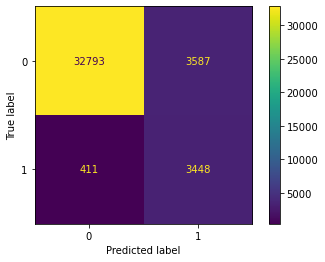

In [10]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay
)

disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, 0], y_pred_class[:, 0]))
disp.plot()

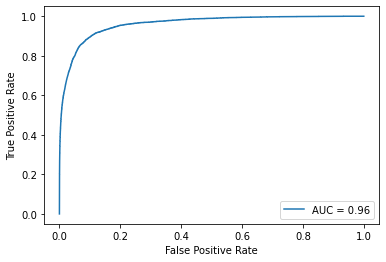

In [11]:
fpr, tpr, thresholds = roc_curve(y_true[:, 0], y_pred[:, 0])
roc_auc = auc(fpr, tpr)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()

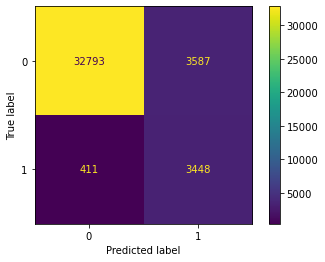

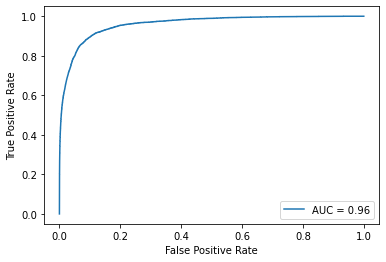

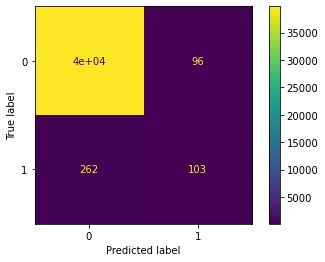

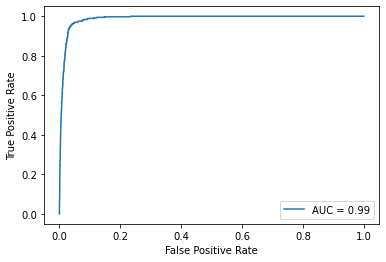

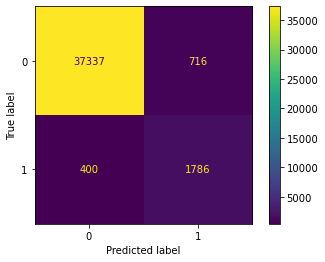

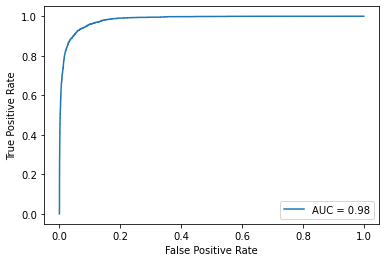

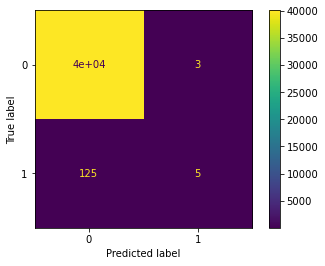

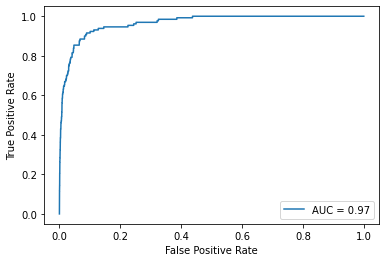

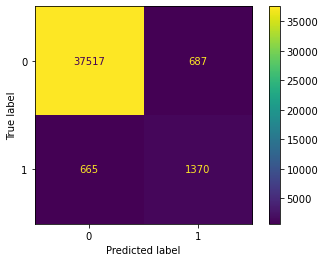

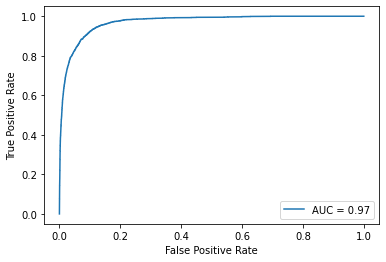

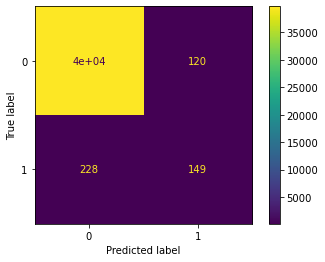

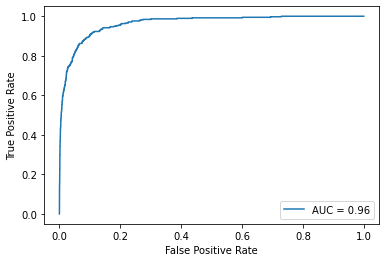

In [13]:
asset_dir = 'results/final/'
os.makedirs(asset_dir, exist_ok=True)

roc_auc_results = []
for i in range(6):
    filename = os.path.join(asset_dir, f'confusion_matrix_{i}.png')
    ConfusionMatrixDisplay(confusion_matrix(y_true[:, i], y_pred_class[:, i])).plot().figure_.savefig(filename)
    
    filename = os.path.join(asset_dir, f'roc_curve_{i}.png')
    fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_results.append(roc_auc)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot().figure_.savefig(filename)

In [17]:
print(sum(roc_auc_results)/len(roc_auc_results))
roc_auc_results

0.9716902876318271


[0.959689468127526,
 0.987800235124203,
 0.9831315409775776,
 0.9655130154943166,
 0.9698823617784984,
 0.9641251042888417]

In [54]:
predictor.delete_endpoint()

In [79]:
import pandas as pd

full_df = pd.read_csv('data/raw_combined.csv')
_, encoded_text = src.utils.encode_text(
    full_df, 
    use_cache=True,
    max_length=500,
    vocab_length=10000
)

In [99]:
# why is class 6, identity hate, so poorly performing?
# pick a few false positives and false negatives

from importlib import reload  
import src.utils
reload(src.utils)

mask = (y_pred[:, 5] < 0.5) & (y_true[:, 5] == 1)
false_neg = X[mask]
false_neg_pred = y_pred[mask]
false_neg_true = y_true[mask]

idx = 10
for i, row in enumerate(encoded_text):
    if np.equal(row, false_neg[idx]).all():
        print(full_df.iloc[i]['comment_text'])
        break
print()
print(' '.join(src.utils.decode_text(false_neg[idx], vocab)))
print(false_neg_pred[idx])
print(false_neg_true[idx])

.

WTF?
Why the fuck do you think that i vandalized the nigger, Oklahoma City Bombing, and prohibition pages? I haven't even been on any of those pages. Thank you douschebag for getting my editing privilages revoked. You are a prick

wtf fuck think vandalized nigger oklahoma city bombing prohibition page havent even page thank <mvt> getting editing <mvt> revoked prick
[9.9999940e-01 1.5343325e-02 9.9999976e-01 4.3093492e-05 9.9999988e-01
 7.3052738e-03]
[1 0 1 0 1 1]


Wow, these comments are awful. But importantly there are lots of misspelled words here. Using a spelling correction tool in the preprocessing would likely help a lot.